<a href="https://colab.research.google.com/github/MilindiSenevirathne/COVID-19_Test/blob/main/Dengue_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geoplot

In [ ]:
!pip install pysal
!pip install splot

In [18]:
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px
import pandas as pd
from geopy.geocoders import Nominatim
import folium
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
from plotnine import *
import plotly.express as px
import json
import IPython
from plotnine import *
import geoplot as gplt
from shapely.geometry import Point
import shapely.geometry
import datetime
from scipy import stats
from pysal.lib import weights
from splot.esda import moran_scatterplot
from shapely import wkt
from sklearn.preprocessing import StandardScaler
import esda
import libpysal as lps

#Dengue Dataset

In [4]:
dengue_df = pd.read_csv('/content/sample_data/dengue_dataset.csv', sep = r'\s*,\s*', engine = 'python')
dengue_df.head()

year  week  start.date    end.date  District  cases  Latitude  Longitude
0  2006    52  12/23/2006  12/29/2006   Colombo     71  6.927079  79.861243
1  2006    52  12/23/2006  12/29/2006   Gampaha     12  7.084048  80.009831
2  2006    52  12/23/2006  12/29/2006  Kalutara     12  6.585395  79.960740
3  2006    52  12/23/2006  12/29/2006     Kandy     20  7.290572  80.633726
4  2006    52  12/23/2006  12/29/2006    Matale      4  7.467465  80.623416

In [5]:
dengue_df.isnull().sum()

year          0
week          0
start.date    0
end.date      0
District      0
cases         0
Latitude      0
Longitude     0
dtype: int64

In [6]:
dengue_df.describe()

year          week         cases      Latitude     Longitude
count  21960.000000  21960.000000  21960.000000  21960.000000  21960.000000
mean    2014.579781     26.435883     29.621812      7.581550     80.636483
std        4.673161     15.176584     81.976917      1.014612      0.575642
min     2006.000000      1.000000      0.000000      5.949631     79.839386
25%     2011.000000     13.000000      2.000000      6.927079     80.216791
50%     2015.000000     26.000000      8.000000      7.358070     80.522547
75%     2019.000000     40.000000     26.000000      8.311352     81.054981
max     2023.000000     53.000000   2631.000000      9.661498     81.830633

In [7]:
dengue_df = gpd.GeoDataFrame(dengue_df, geometry=gpd.points_from_xy(
    dengue_df.Longitude, dengue_df.Latitude
))

dengue_df.head()

year  week  start.date    end.date  District  cases  Latitude  Longitude  \
0  2006    52  12/23/2006  12/29/2006   Colombo     71  6.927079  79.861243   
1  2006    52  12/23/2006  12/29/2006   Gampaha     12  7.084048  80.009831   
2  2006    52  12/23/2006  12/29/2006  Kalutara     12  6.585395  79.960740   
3  2006    52  12/23/2006  12/29/2006     Kandy     20  7.290572  80.633726   
4  2006    52  12/23/2006  12/29/2006    Matale      4  7.467465  80.623416   

                   geometry  
0  POINT (79.86124 6.92708)  
1  POINT (80.00983 7.08405)  
2  POINT (79.96074 6.58539)  
3  POINT (80.63373 7.29057)  
4  POINT (80.62342 7.46746)

/usr/local/lib/python3.10/dist-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_fill_gradient2 could not recognise parameter `high_l`


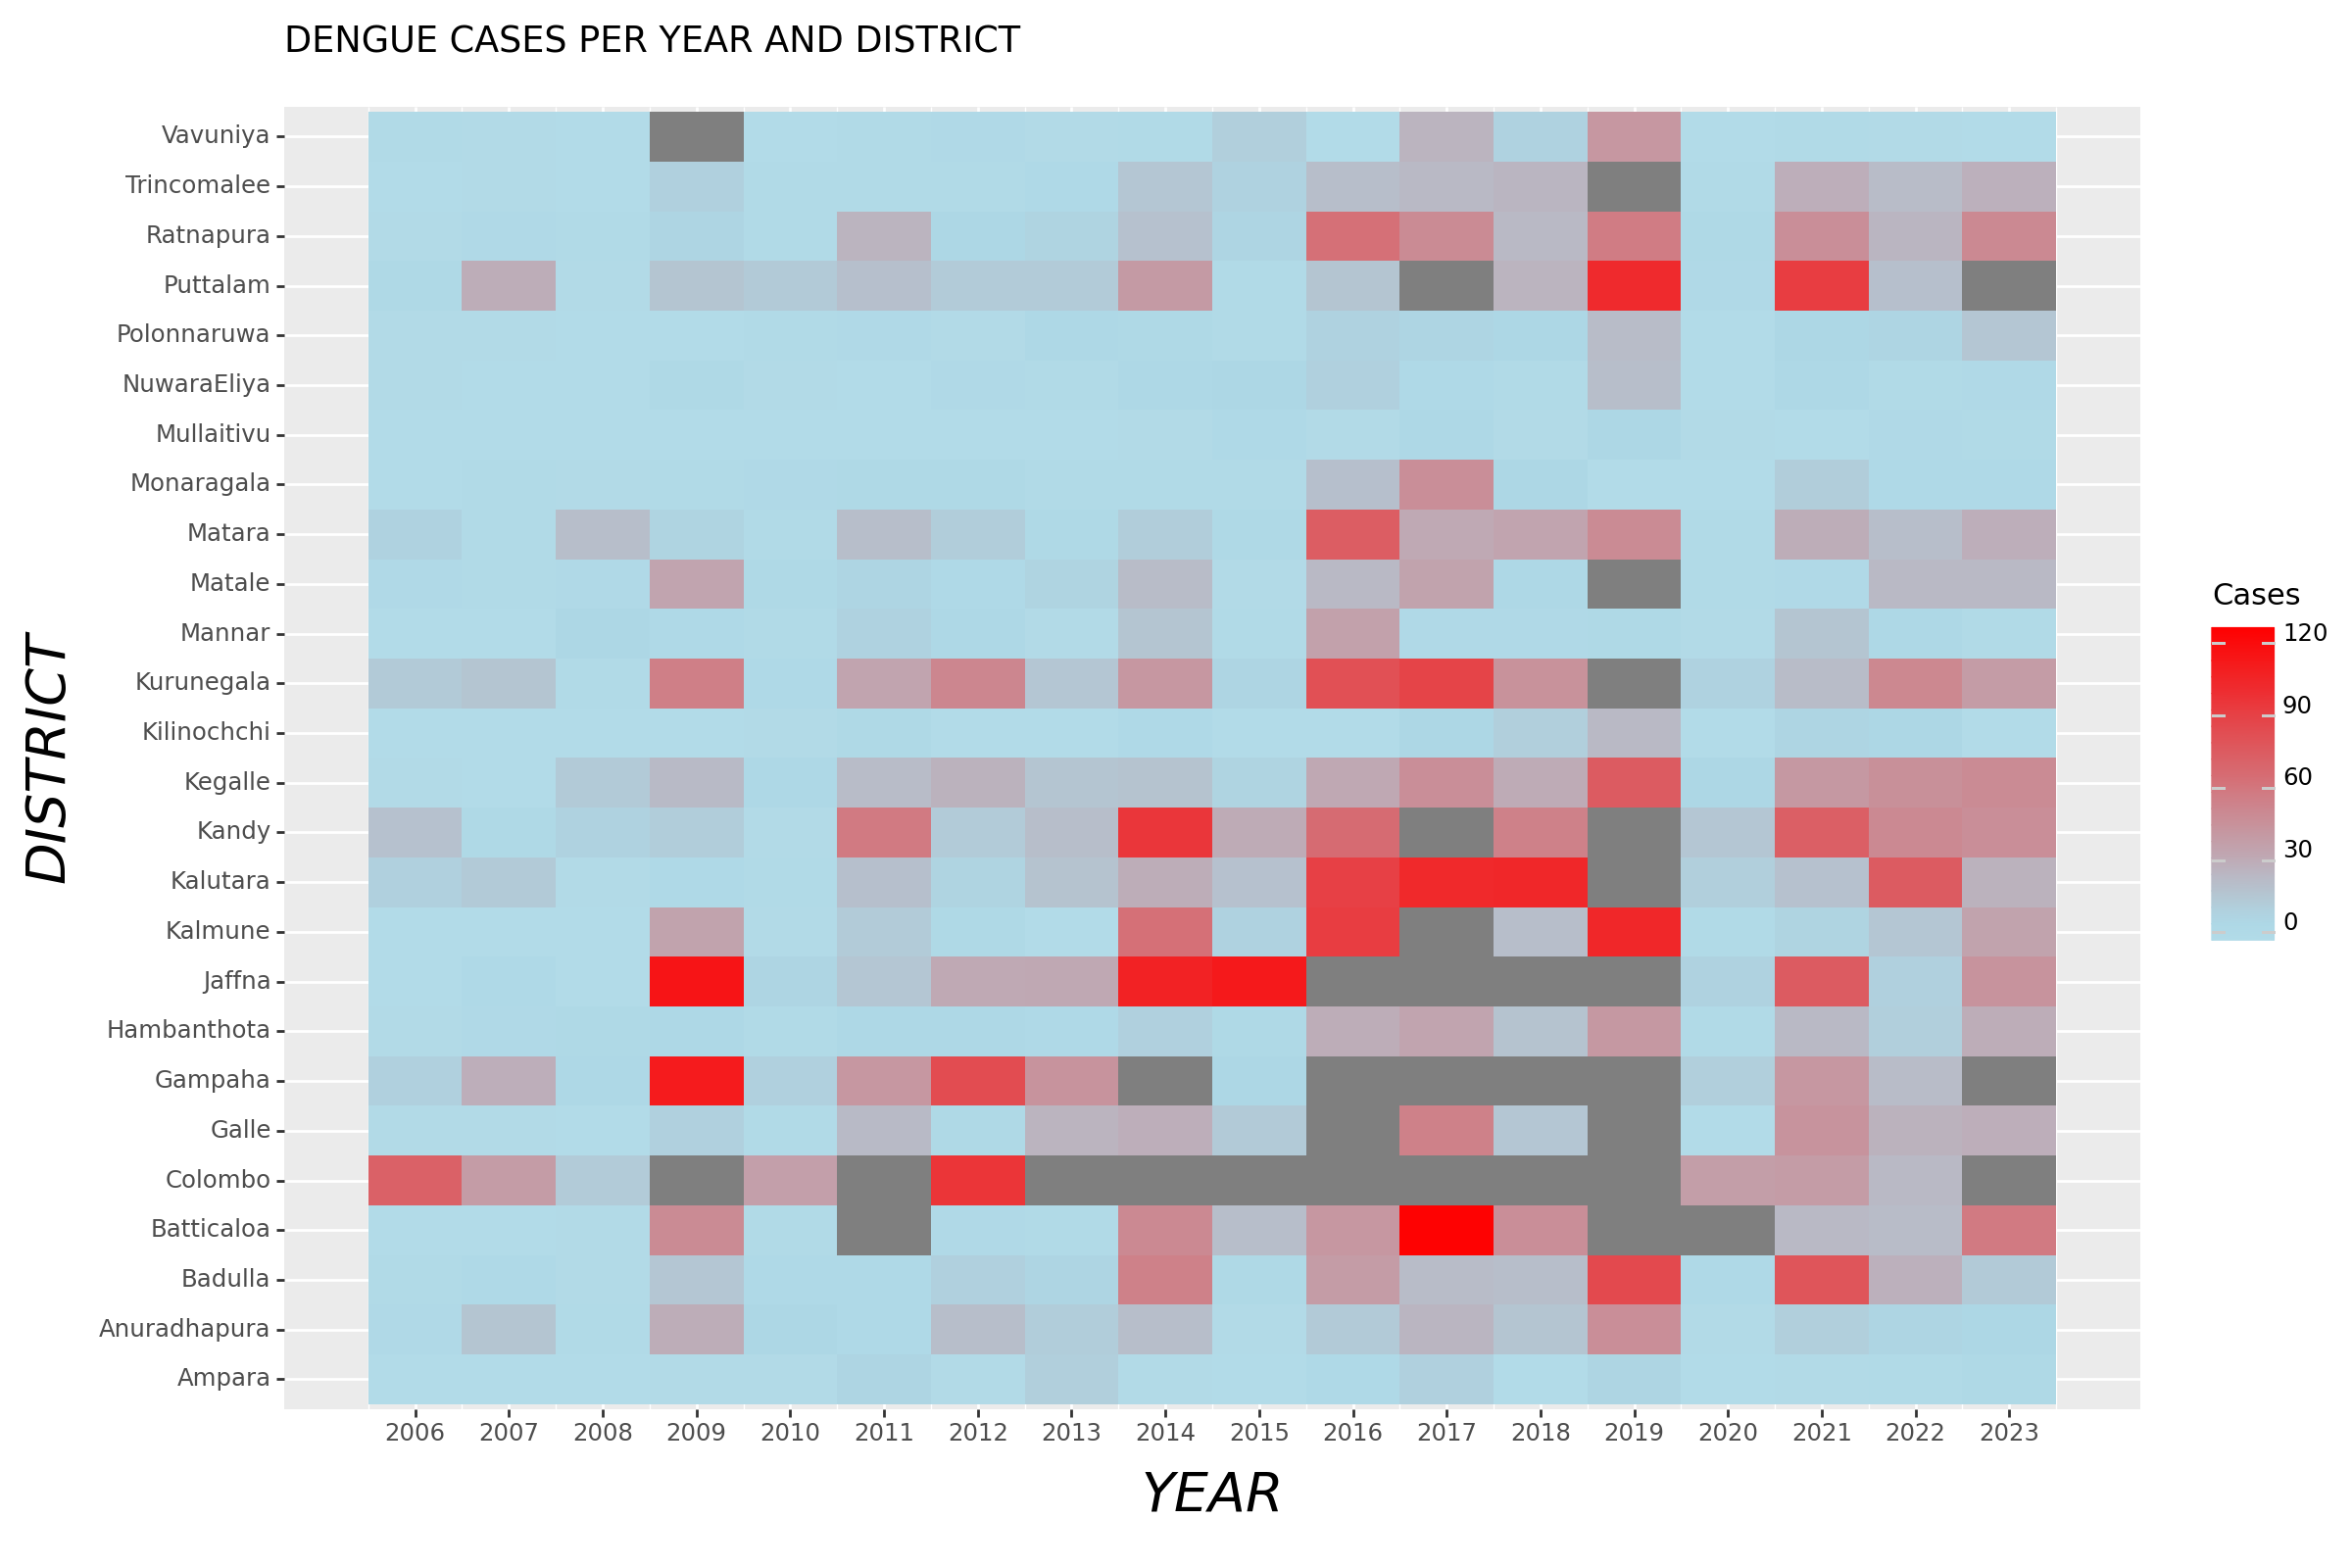

<Figure Size: (1200 x 800)>

In [8]:
midpoint_value = dengue_df['cases'].quantile(0.5)

max_value = dengue_df['cases'].quantile(0.95)

(
    ggplot(dengue_df, aes('year', 'District', fill='cases')) +
    geom_tile() +
    scale_fill_gradient2(low="white", mid="lightblue", high="red",
                         midpoint=midpoint_value,
                         limits=[0, max_value],
                         high_l=0.5) +
    scale_x_continuous(breaks=range(2006, 2024, 1)) +
    labs(x="YEAR", y="DISTRICT", fill="Cases",
         title="DENGUE CASES PER YEAR AND DISTRICT") +
    theme(
        axis_title_x=element_text(size=20, face="italic"),
        axis_title_y=element_text(size=20, face="italic"),
        figure_size=(12, 8)
    )
)

In [9]:
sl_map  = dengue_df.groupby(['year', 'District','Latitude','Longitude'])['cases'].sum()


sl_map = sl_map.reset_index()
sl_map.head()
sl_map['size'] = sl_map['cases']*90000000
sl_map
fig = px.scatter_mapbox(sl_map, lat="Latitude", lon="Longitude",
                     color="cases", size='size',hover_data=['District'],
                     color_continuous_scale='burgyl', animation_frame="year",
                     title='Spread total cases over time in Sri Lanka')
fig.update(layout_coloraxis_showscale=True)
fig.update_layout(mapbox_style="carto-positron", mapbox_zoom=3, mapbox_center = {"lat":7.8731,"lon":80.7718})
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.show()

/usr/local/lib/python3.10/dist-packages/plotnine/themes/themeable.py:1902: FutureWarning:

You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.



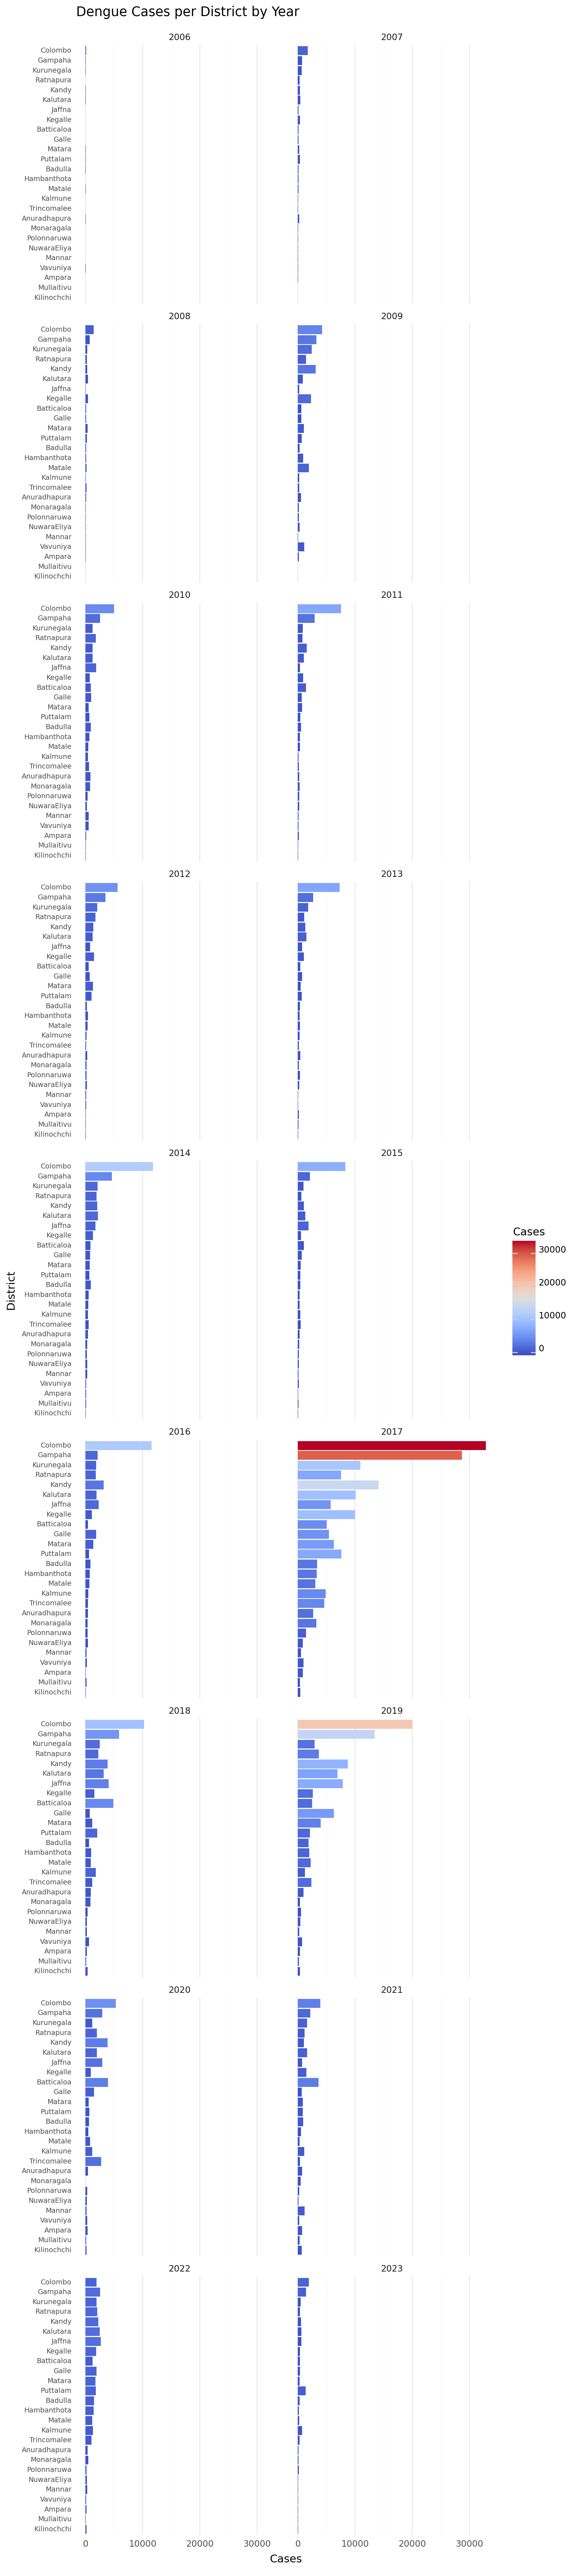

In [10]:
dengue_df_sorted = dengue_df.groupby(['District', 'year'])['cases'].sum().reset_index()

number_of_years = dengue_df_sorted['year'].nunique()
nrows = int(np.ceil(number_of_years / 2))

diverging_plots = (
    ggplot(dengue_df_sorted, aes(x='reorder(District, cases)', y='cases', fill='cases')) +
    geom_col() +
    coord_flip() +
    scale_fill_cmap('coolwarm') +
    facet_wrap('~year', nrow=nrows) +
    labs(y='Cases', x='District', fill='Cases',
         title='Dengue Cases per District by Year') +
    theme_minimal() +
    theme(
        panel_grid_major_y=element_blank(),
        panel_grid_minor_y=element_blank(),
        axis_text_y=element_text(size=7, angle=0),
        figure_size=(8, 4 * nrows),
        subplots_adjust={'wspace': 0.2, 'hspace': 0.3}
    )
)

diverging_plots.draw()

In [11]:
dengue_df['District'] = dengue_df['District'].apply(lambda x: f"{x} District")
sl_districts = gpd.read_file('/content/sample_data/sl.geojson')

gdf = gpd.GeoDataFrame(dengue_df, geometry='geometry')

cases_by_district = gdf.groupby(['District', 'year'])['cases'].sum().reset_index()

merged = sl_districts.merge(cases_by_district, how='left', left_on='shapeName', right_on='District')
merged.head()

shapeName shapeISO                  shapeID shapeGroup shapeType  \
0  Jaffna District    LK-41  46371173B17589711796788        LKA      ADM2   
1  Jaffna District    LK-41  46371173B17589711796788        LKA      ADM2   
2  Jaffna District    LK-41  46371173B17589711796788        LKA      ADM2   
3  Jaffna District    LK-41  46371173B17589711796788        LKA      ADM2   
4  Jaffna District    LK-41  46371173B17589711796788        LKA      ADM2   

                                            geometry         District    year  \
0  MULTIPOLYGON (((79.71520 9.52947, 79.71370 9.5...  Jaffna District  2006.0   
1  MULTIPOLYGON (((79.71520 9.52947, 79.71370 9.5...  Jaffna District  2007.0   
2  MULTIPOLYGON (((79.71520 9.52947, 79.71370 9.5...  Jaffna District  2008.0   
3  MULTIPOLYGON (((79.71520 9.52947, 79.71370 9.5...  Jaffna District  2009.0   
4  MULTIPOLYGON (((79.71520 9.52947, 79.71370 9.5...  Jaffna District  2010.0   

    cases  
0     0.0  
1   117.0  
2    19.0  
3   190.0  
4  1830.0

In [12]:
gdf_sorted = merged.sort_values(by=['year', 'cases'])

gdf_cleaned = gdf_sorted.dropna(subset=['District', 'year', 'cases'])

gdf_cleaned['year'] = gdf_cleaned['year'].astype(int)
gdf_cleaned['cases'] = gdf_cleaned['cases'].astype(float)

unique_years = gdf_cleaned['year'].unique()

num_rows = len(unique_years) // 2 + len(unique_years) % 2

fig, axs = plt.subplots(num_rows, 2, figsize=(20, 10 * num_rows))
axs = axs.flatten()

for i, year in enumerate(unique_years):
    year_data = gdf_cleaned[gdf_cleaned['year'] == year]

    year_data.plot(column='cases', cmap='OrRd', linewidth=0.8, ax=axs[i], edgecolor='0.8', legend=True,
                   legend_kwds={'label': "Number of Cases", 'orientation': "horizontal"})
    axs[i].set_aspect('equal')
    axs[i].set_title(f'Dengue Cases in Sri Lanka - {year}')
    axs[i].axis('off')

for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#Feature Extraction


In [13]:
dengue_df['start.date'] = pd.to_datetime(dengue_df['start.date'])
dengue_df['end.date'] = pd.to_datetime(dengue_df['end.date'])

In [14]:
dengue_df['time point'] = dengue_df['year'].astype(str) + "_week_" + dengue_df['week'].astype(str).str.zfill(2)

In [15]:
dengue_df.head()

year  week start.date   end.date           District  cases  Latitude  \
0  2006    52 2006-12-23 2006-12-29   Colombo District     71  6.927079   
1  2006    52 2006-12-23 2006-12-29   Gampaha District     12  7.084048   
2  2006    52 2006-12-23 2006-12-29  Kalutara District     12  6.585395   
3  2006    52 2006-12-23 2006-12-29     Kandy District     20  7.290572   
4  2006    52 2006-12-23 2006-12-29    Matale District      4  7.467465   

   Longitude                  geometry    time point  
0  79.861243  POINT (79.86124 6.92708)  2006_week_52  
1  80.009831  POINT (80.00983 7.08405)  2006_week_52  
2  79.960740  POINT (79.96074 6.58539)  2006_week_52  
3  80.633726  POINT (80.63373 7.29057)  2006_week_52  
4  80.623416  POINT (80.62342 7.46746)  2006_week_52

## Calculate mean, standard deviation, minimum, maximum of cases weekly wise

In [31]:
grouped = dengue_df.groupby('time point')['cases']

feature_set_1 = grouped.agg(
    mean_cases='mean',
    std_cases='std',
    min_cases='min',
    max_cases='max',
    skewness_cases=lambda x: stats.skew(x, nan_policy='omit'),
    kurtosis_cases=lambda x: stats.kurtosis(x, nan_policy='omit')
).reset_index()

feature_pool = pd.DataFrame(feature_set_1)
feature_pool.head()

time point  mean_cases  std_cases  min_cases  max_cases  skewness_cases  \
0  2006_week_52    6.423077  14.311319          0         71        3.752290   
1  2007_week_01    6.961538  11.119283          0         41        2.205685   
2  2007_week_02    6.269231  10.211984          0         43        2.270241   
3  2007_week_03    5.038462   8.121481          0         38        2.807865   
4  2007_week_04    5.538462  10.527035          0         52        3.541409   

   kurtosis_cases  
0       14.311144  
1        4.046724  
2        4.978085  
3        8.564278  
4       12.904893

## Calculate Global Moran's Index for each time point

In [17]:
# Standardize the 'cases' column
scaler = StandardScaler()
cases = dengue_df['cases'].values.reshape(-1, 1)
dengue_df['standardized_cases'] = scaler.fit_transform(cases)
dengue_df.head()

year  week start.date   end.date           District  cases  Latitude  \
0  2006    52 2006-12-23 2006-12-29   Colombo District     71  6.927079   
1  2006    52 2006-12-23 2006-12-29   Gampaha District     12  7.084048   
2  2006    52 2006-12-23 2006-12-29  Kalutara District     12  6.585395   
3  2006    52 2006-12-23 2006-12-29     Kandy District     20  7.290572   
4  2006    52 2006-12-23 2006-12-29    Matale District      4  7.467465   

   Longitude                  geometry    time point  standardized_cases  
0  79.861243  POINT (79.86124 6.92708)  2006_week_52            0.504766  
1  80.009831  POINT (80.00983 7.08405)  2006_week_52           -0.214966  
2  79.960740  POINT (79.96074 6.58539)  2006_week_52           -0.214966  
3  80.633726  POINT (80.63373 7.29057)  2006_week_52           -0.117375  
4  80.623416  POINT (80.62342 7.46746)  2006_week_52           -0.312556

In [ ]:
k_values = range(1, 21)

optimal_moran_results = pd.DataFrame(columns=['time_point', 'global_morans_I'])

for time_point in dengue_df['time point'].unique():
    time_point_data = dengue_df[dengue_df['time point'] == time_point]
    global_morans_I = -float('inf')
    optimal_k = None

    for k in k_values:
        w = lps.weights.KNN.from_dataframe(time_point_data, k=k)
        w.transform = 'R'
        mi = esda.Moran(time_point_data['standardized_cases'], w)

        if mi.I > global_morans_I:
            global_morans_I = mi.I
            optimal_k = k

    optimal_moran_results = optimal_moran_results.append({'time_point': time_point, 'global_morans_I': global_morans_I}, ignore_index=True)

In [21]:
optimal_moran_results.head()

time_point  max_morans_I
0  2006_week_52      0.241548
1  2007_week_01      0.248466
2  2007_week_02      0.448108
3  2007_week_03      0.627504
4  2007_week_04      0.458102

In [32]:
temp_df = optimal_moran_results[['time_point', 'max_morans_I']]
feature_pool = feature_pool.merge(temp_df, how='left', left_on='time point', right_on='time_point')
feature_pool.drop('time_point', axis=1, inplace=True)
feature_pool.head()

time point  mean_cases  std_cases  min_cases  max_cases  skewness_cases  \
0  2006_week_52    6.423077  14.311319          0         71        3.752290   
1  2007_week_01    6.961538  11.119283          0         41        2.205685   
2  2007_week_02    6.269231  10.211984          0         43        2.270241   
3  2007_week_03    5.038462   8.121481          0         38        2.807865   
4  2007_week_04    5.538462  10.527035          0         52        3.541409   

   kurtosis_cases  max_morans_I  
0       14.311144      0.241548  
1        4.046724      0.248466  
2        4.978085      0.448108  
3        8.564278      0.627504  
4       12.904893      0.458102

In [33]:
from scipy.spatial import cKDTree

def average_nearest_neighbor_distance(group):
    # Extract the coordinates of the points
    coordinates = np.array(list(zip(group.geometry.x, group.geometry.y)))

    # Build a KDTree for efficient nearest neighbor search
    tree = cKDTree(coordinates)

    # Query the tree for nearest neighbors (excluding each point itself)
    distances, _ = tree.query(coordinates, k=2)

    # Return the average distance (excluding distance to self, hence distances[:, 1])
    return distances[:, 1].mean()

# Group by 'time point' and apply the function
ann_per_time_point = dengue_df.groupby('time point').apply(average_nearest_neighbor_distance)

# Result
print(ann_per_time_point)

time point
2006_week_52    0.372934
2007_week_01    0.372934
2007_week_02    0.372934
2007_week_03    0.372934
2007_week_04    0.372934
                  ...   
2023_week_04    0.372934
2023_week_05    0.372934
2023_week_06    0.372934
2023_week_07    0.372934
2023_week_08    0.372934
Length: 844, dtype: float64
